In [1]:
import glob
from pathlib import Path
import infercnvpy as cnv
import genomic_features as gf
import traceback
import scanpy as sc
import numpy as np
import pandas as pd
import os
import gc
import anndata as ad
import sys
import traceback
import matplotlib.pyplot as plt
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
from scipy.stats import median_abs_deviation
import seaborn as sns


In [2]:
adata_sc = sc.read_h5ad('../single_cell_int/adata_sc_int.h5ad')

In [46]:
def is_outlier(data, nmads=5):
    median = np.median(data)
    mad = median_abs_deviation(data)
    return (data < median - nmads * mad) | (data > median + nmads * mad)
    
# adata_sc.obs['is_outlier_total_counts'] = is_outlier(adata_sc.obs["total_counts"], 2.5)

In [22]:
adata_sc.var["mito"] = adata_sc.var_names.str.startswith("MT-")

In [25]:
adata_sc.var.groupby(['mito']).size()

mito
False    39011
True        13
dtype: int64

In [26]:
sc.pp.calculate_qc_metrics(adata_sc, inplace=True, qc_vars=["mito"] )

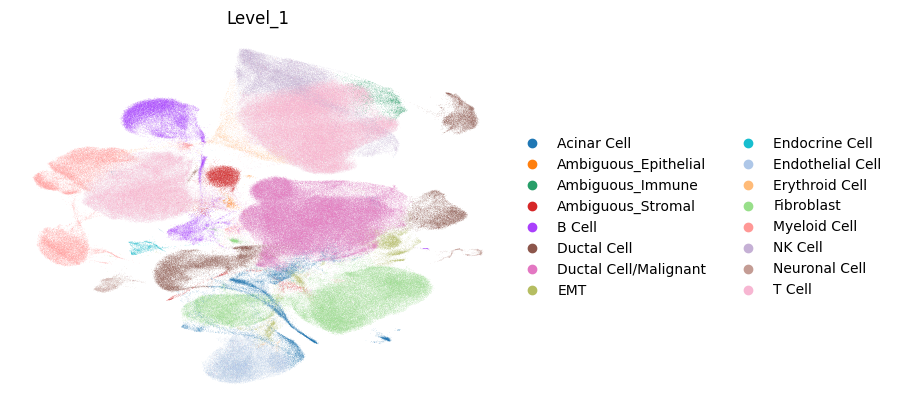

In [11]:
adata_sc.obsm['X_umap'] = adata_sc.obsm['X_umap_int']
sc.pl.umap(adata_sc, color='Level_1', frameon=False)

In [38]:
cols_removed = []
for col in adata_sc.obs.columns:
    if adata_sc.obs[col].isna().all():
        print(f"Column '{col}' contains only NaN values.")
        cols_removed.append(col)

Column 'sampleid' contains only NaN values.
Column 'scrublet_scores' contains only NaN values.
Column 'pid' contains only NaN values.
Column 'n_counts_sat' contains only NaN values.
Column 'n_genes_sat' contains only NaN values.
Column 'percent_mito' contains only NaN values.
Column 'Moffitt_basal' contains only NaN values.
Column 'Moffitt_classical' contains only NaN values.
Column 'Bailey_squamous' contains only NaN values.
Column 'Bailey_progenitor' contains only NaN values.
Column 'Collison_QM' contains only NaN values.
Column 'Collison_classical' contains only NaN values.
Column 'MALIGNANT CELLS' contains only NaN values.
Column 'ACINAR' contains only NaN values.
Column 'Alpha' contains only NaN values.
Column 'Beta' contains only NaN values.
Column 'Delta' contains only NaN values.
Column 'Gamma' contains only NaN values.
Column 'Episilon' contains only NaN values.
Column 'ENDOCRINE' contains only NaN values.
Column 'ENDOTHELIAL' contains only NaN values.
Column 'Pan_Immune' cont

In [47]:
adata_sc.obs = adata_sc.obs.drop(columns=cols_removed)

In [65]:
adata_sc.obs['outlier'] = False
skip_list = ['Ductal Cell/Malignant', 'Ductal Cell', 'Acinar Cell']
for dataset in adata_sc.obs['Dataset'].unique():
    for cell in adata_sc.obs.loc[adata_sc.obs['Dataset'] == dataset, 'Level_1'].unique():
        if cell in skip_list:
            print(f'Skipping for {cell} in {dataset}')
            continue
        cell_mask = (adata_sc.obs['Dataset'] == dataset) & (adata_sc.obs['Level_1'] == cell)
        total_outliers = pd.Series(False, index=adata_sc.obs.index)
        outlier_total_counts = is_outlier(adata_sc.obs.loc[cell_mask, 'log1p_total_counts'], 4)
        outlier_n_genes = is_outlier(adata_sc.obs.loc[cell_mask, 'log1p_n_genes_by_counts'], 4)
        outlier_mito = is_outlier(adata_sc.obs.loc[cell_mask, 'pct_counts_mito'], 4)
        combined_outlier = outlier_total_counts | outlier_n_genes | outlier_mito
        adata_sc.obs.loc[cell_mask, 'outlier'] |= combined_outlier

Skipping for Ductal Cell/Malignant in Ding
Skipping for Ductal Cell in Ding
Skipping for Acinar Cell in Ding
Skipping for Ductal Cell/Malignant in Lee
Skipping for Acinar Cell in Lee
Skipping for Ductal Cell in Lee
Skipping for Ductal Cell/Malignant in Simeone
Skipping for Ductal Cell in Simeone
Skipping for Acinar Cell in Simeone
Skipping for Ductal Cell/Malignant in Steele
Skipping for Ductal Cell in Steele
Skipping for Acinar Cell in Steele
Skipping for Ductal Cell/Malignant in Peng
Skipping for Ductal Cell in Peng
Skipping for Acinar Cell in Peng
Skipping for Ductal Cell/Malignant in Caronni
Skipping for Ductal Cell in Caronni
Skipping for Acinar Cell in Caronni
Skipping for Ductal Cell/Malignant in Zhang
Skipping for Acinar Cell in Zhang
Skipping for Ductal Cell in Zhang
Skipping for Ductal Cell/Malignant in Lin
Skipping for Acinar Cell in Lin
Skipping for Ductal Cell in Lin
Skipping for Ductal Cell/Malignant in Schlesinger
Skipping for Ductal Cell in Schlesinger
Skipping for Acin

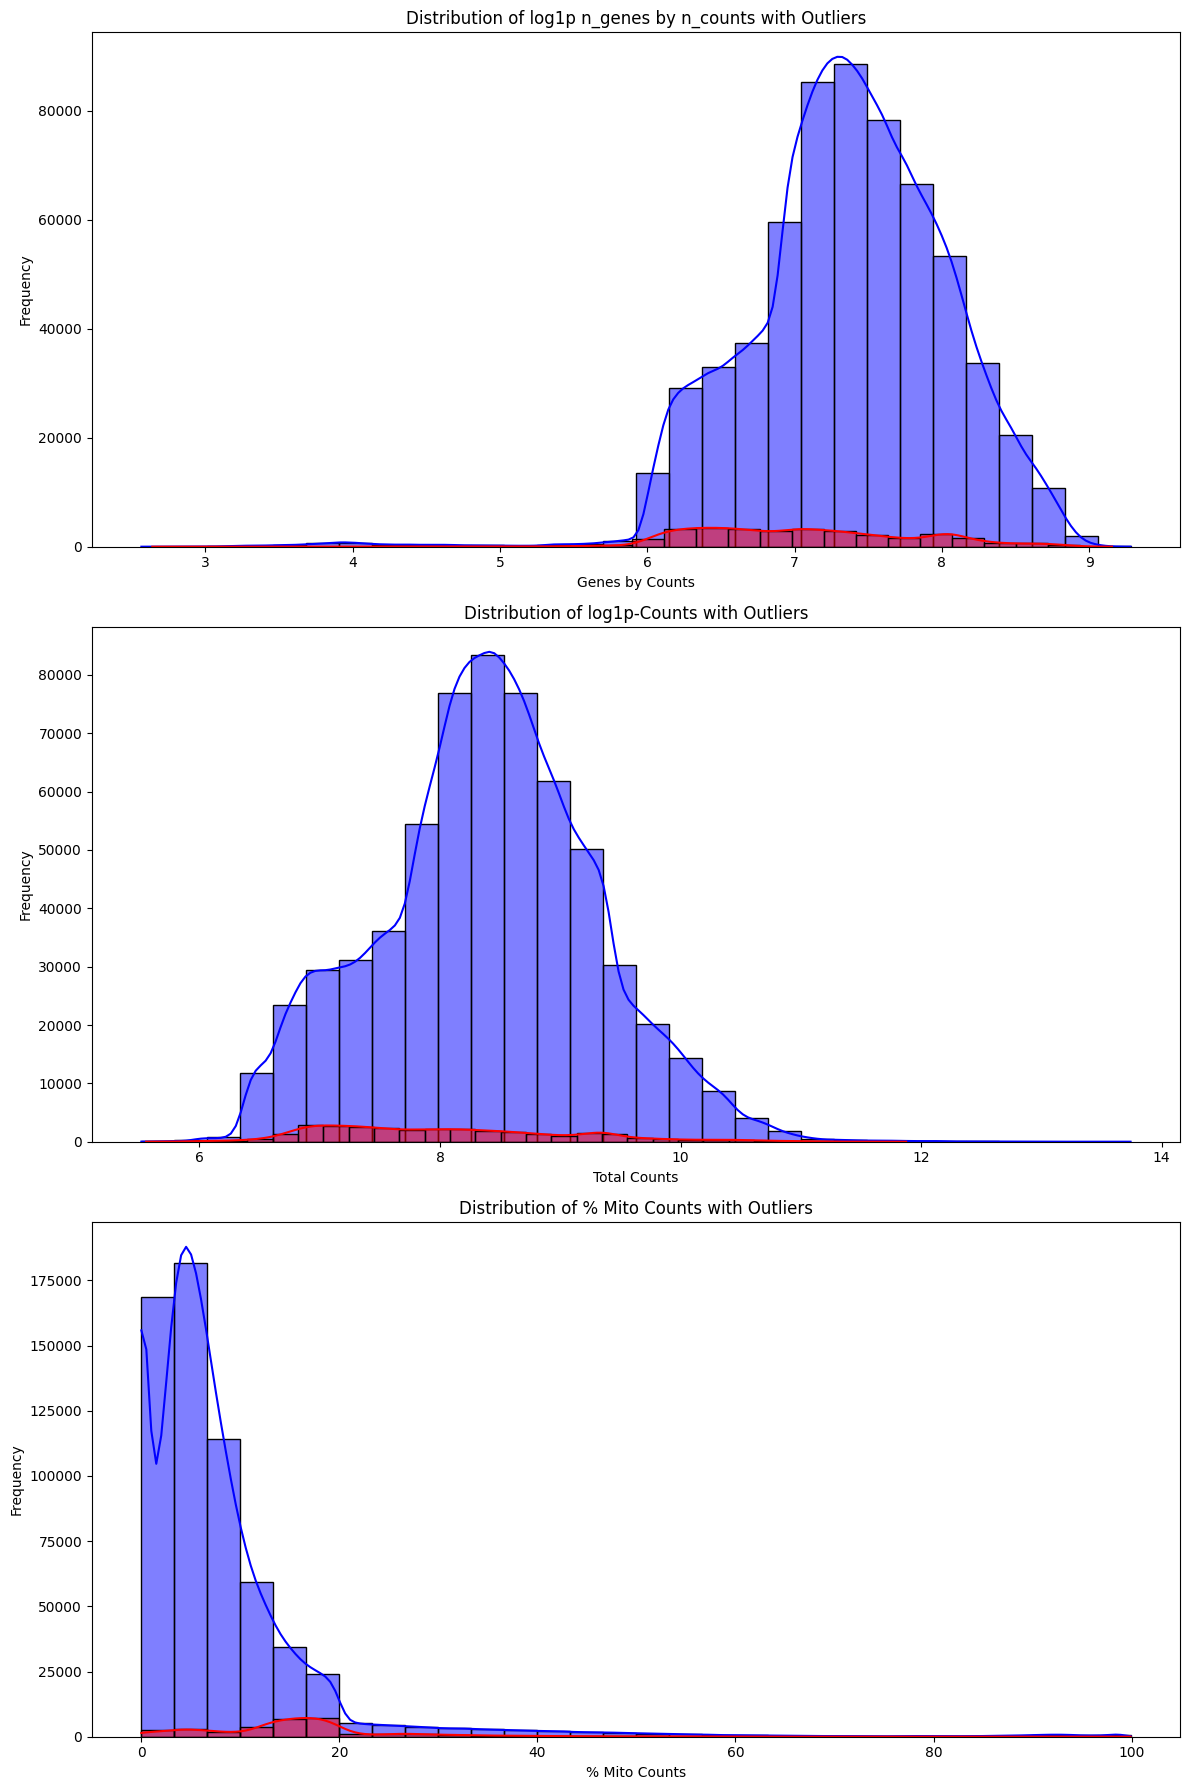

In [66]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(12, 18))
# plt.figure()
sns.histplot(adata_sc.obs['log1p_n_genes_by_counts'], bins=30, kde=True, color="blue", label='Data', ax=ax1)
sns.histplot(adata_sc.obs.loc[adata_sc.obs['outlier'], 'log1p_n_genes_by_counts'], bins=30, kde=True, color="red", label='Outliers', ax=ax1)
ax1.set_xlabel('Genes by Counts')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of log1p n_genes by n_counts with Outliers')

sns.histplot(adata_sc.obs['log1p_total_counts'], bins=30, kde=True, color="blue", label='Data', ax=ax2)
sns.histplot(adata_sc.obs.loc[adata_sc.obs['outlier'], 'log1p_total_counts'], bins=30, kde=True, color="red", label='Outliers', ax=ax2)
ax2.set_xlabel('Total Counts')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of log1p-Counts with Outliers')

sns.histplot(adata_sc.obs['pct_counts_mito'], bins=30, kde=True, color="blue", label='Data', ax=ax3)
sns.histplot(adata_sc.obs.loc[adata_sc.obs['outlier'], 'pct_counts_mito'], bins=30, kde=True, color="red", label='Outliers', ax=ax3)
ax3.set_xlabel('% Mito Counts')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of % Mito Counts with Outliers')

plt.tight_layout()
plt.show()

In [67]:
size_filtered = adata_sc[~adata_sc.obs.outlier].obs.groupby('Level_1').size()
size_unfiltered = adata_sc.obs.groupby('Level_1').size()
df = pd.DataFrame({
    'Unfiltered': size_unfiltered,
    'Filtered': size_filtered
})
df['Cells_Removed'] = df.Unfiltered - df.Filtered
df.loc["Total"] = df.sum()
df

,Unfiltered,Filtered,Cells_Removed
Level_1,,,
Acinar Cell,19388,19388,0
Ambiguous_Epithelial,738,617,121
Ambiguous_Immune,3749,3370,379
Ambiguous_Stromal,11483,8878,2605
B Cell,29901,28079,1822
Ductal Cell,39073,39073,0
Ductal Cell/Malignant,141424,141424,0
EMT,11040,10781,259
Endocrine Cell,1826,1760,66


In [68]:
size_filtered = adata_sc[~adata_sc.obs.outlier].obs.groupby('Dataset').size()
size_unfiltered = adata_sc.obs.groupby('Dataset').size()
df = pd.DataFrame({
    'Unfiltered': size_unfiltered,
    'Filtered': size_filtered
})
df['Cells_Removed'] = df.Unfiltered - df.Filtered
df.loc["Total"] = df.sum()
df.sort_values(by='Cells_Removed', ascending=False)

,Unfiltered,Filtered,Cells_Removed
Dataset,,,
Total,617160,586986,30174
Simeone,213711,202124,11587
Ding,152124,145616,6508
Caronni,75280,70650,4630
Zhang,37934,35579,2355
Steele,37218,35768,1450
Steele_Adj_Norm,10903,9896,1007
Lin,17086,16097,989
Schlesinger,6499,5873,626


In [69]:
adata_sc.obs.groupby('outlier').size()

outlier
False    586986
True      30174
dtype: int64

In [71]:
adata_sc.obs.outlier = adata_sc.obs.outlier.map({True: 1, False: 0})

In [95]:
adata_sc.obs.level0_leiden_subcluster.unique()

AAACCCAAGTCATCGT-1-HT056P-S1PAA1-0-0-0                  Immune Cell_1
AAACCCACAACCACGC-1-HT056P-S1PAA1-0-0-0                 Stromal Cell_1
AAACCCACAACTCCCT-1-HT056P-S1PAA1-0-0-0                  Immune Cell_0
AAACCCACAGACAATA-1-HT056P-S1PAA1-0-0-0                  Immune Cell_0
AAACCCACATGCCGAC-1-HT056P-S1PAA1-0-0-0                  Immune Cell_0
                                                     ...             
N11_TTTGCGCGTGCGCTTG                      Epithelial/Malignant Cell_7
N11_TTTGGTTCATTGAGCT                      Epithelial/Malignant Cell_4
N11_TTTGGTTGTCCGACGT                      Epithelial/Malignant Cell_2
N11_TTTGTCAAGGCTAGCA                      Epithelial/Malignant Cell_4
N11_TTTGTCACATCGGACC                      Epithelial/Malignant Cell_7
Name: level0_leiden_subcluster, Length: 617160, dtype: category
Categories (41, object): ['Ambiguous_0', 'Ambiguous_1', 'Ambiguous_2', 'Ambiguous_8', ..., 'Stromal Cell_7', 'Stromal Cell_8', 'Stromal Cell_9', 'Unknown']

In [ ]:
temp = {    'immune_0': 'T Cell',
    'immune_1': 'T Cell',
    'immune_2': 'NK Cell',
    'immune_3': 'B Cell',
    'immune_4': 'Myeloid Cell',
    'immune_5': 'Myeloid Cell',
    'immune_6': 'B Cell',
    'immune_7': 'Erythroid Cell',
    'immune_8': 'Ambiguous_Immune',
    'immune_9': 'Myeloid Cell',
    'immune_10': 'Ambiguous_Immune',
    'stromal_0': 'Fibroblast',
    'stromal_1': 'Fibroblast',
    'stromal_2': 'Fibroblast',
    'stromal_3': 'Endothelial Cell',
    'stromal_4': 'Ambiguous_Stromal',
    'stromal_5': 'Fibroblast',
    'stromal_6': 'Adipocyte',
    'stromal_7': 'Acinar Cell',
    'stromal_8': 'Adipocyte',
    'stromal_9': 'Myeloid Cell',
    'epithelial_0': 'Ductal Cell/Malignant',
    'epithelial_1': 'Ductal Cell/Malignant',
    'epithelial_2': 'Ductal Cell',
    'epithelial_3': 'Ductal Cell',
    'epithelial_4': 'Acinar Cell',
    'epithelial_5': 'Ductal Cell',
    'epithelial_6': 'Acinar Cell',
    'epithelial_7': 'Acinar Cell',
    'epithelial_8': 'EMT',
    'epithelial_9': 'EMT',
    'epithelial_10': 'EMT',
    'epithelial_11': 'Myeloid Cell',
    'epithelial_12': 'B Cell',
    'epithelial_13': 'Ambiguous_Epithelial',
    'epithelial_14': 'Ductal Cell/Malignant'}
celltype_subcluster = {key.replace('immune_', 'Immune Cell_').replace('stromal_', 'Stromal Cell_').replace('epithelial_', 'Epithelial/Malignant Cell_'): value
                       for key, value in temp.items()}


adata_sc.obs['Level_1'] = adata_sc.obs['Level_0']
adata_sc.obs['Level_1'] = adata_sc.obs['level0_leiden_subcluster'].map(celltype_subcluster).fillna(adata_sc.obs['Level_0'])

In [102]:
adata_sc.obs.groupby('Level_1').size()

Level_1
Acinar Cell               19388
Adipocyte                  2574
Ambiguous_Epithelial        738
Ambiguous_Immune           3749
Ambiguous_Stromal          8909
B Cell                    29901
Ductal Cell               39073
Ductal Cell/Malignant    141424
EMT                       11040
Endocrine Cell             1826
Endothelial Cell          23149
Erythroid Cell             4356
Fibroblast                79020
Myeloid Cell              35896
NK Cell                   30858
Neuronal Cell              3111
T Cell                   182148
dtype: int64

... storing 'Level_1' as categorical


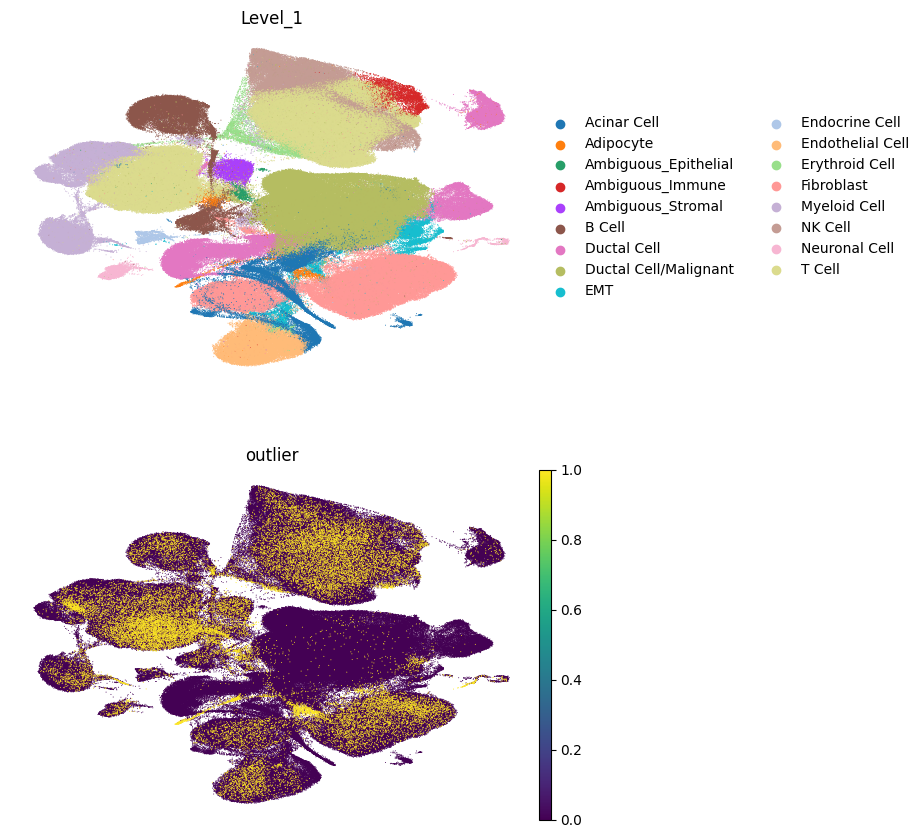

In [103]:
sc.pl.umap(adata_sc, color=['Level_1', 'outlier'], frameon=False, ncols=1, size=2)

In [104]:
adata_sc.write('../single_cell_int/adata_sc_int_outlier.h5ad')

# Single NUC

In [2]:
adata_filtered = sc.read_h5ad('../../PDAC/processed_datasets/All_genes/Concat_All_Genes_filtered.h5ad')

In [3]:
adata_filtered

AnnData object with n_obs × n_vars = 868218 × 39024
    obs: 'n_genes', 'ID', 'n_counts', 'log_counts', 'mt_frac', 'Dataset', 'sampleid', 'scrublet_scores', 'pid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts_sat', 'n_genes_sat', 'percent_mito', 'leiden', 'batch', 'Moffitt_basal', 'Moffitt_classical', 'Bailey_squamous', 'Bailey_progenitor', 'Collison_QM', 'Collison_classical', 'MALIGNANT CELLS', 'ACINAR', 'Alpha', 'Beta', 'Delta', 'Gamma', 'Episilon', 'ENDOCRINE', 'ENDOTHELIAL', 'Pan_Immune', 'AntigenPresentingCells', 'Monocytes_1', 'Monocytes_2', 'Macrophage', 'cDC1', 'cDC2', 'DC_activated', 'pDC', 'Mast', 'Eosinophils', 'Neutrophils', 'M0', 'M1', 'M2', 'Mast_Resting', 'Mast_activated', 'CD8_Tcells', 'CD4_Tcells', 'NK', 'CD8_gammadelta', 'CD8_exhausted', 'CD4_naive', 'CD4_memory_resting', 'CD4_memory_activated', 'CD4_follicular_helper', 'CD4_regulatory', 'NK_resting', 'NK_activated', 'B_cell', 'Plasma', 'Bcell_naive', 'Bcell_memory', 

In [3]:
adata_sn = sc.read_h5ad('../single_nuc_int/single_nuc_int.h5ad')

In [4]:
adata_sn_all = adata_filtered[adata_filtered.obs.batch_covariate.isin(['Regev_snRNA-seq', 'Ding_snRNA-seq'])]

In [5]:
adata_sn

AnnData object with n_obs × n_vars = 251058 × 2269
    obs: 'n_genes', 'ID', 'n_counts', 'log_counts', 'mt_frac', 'Dataset', 'sampleid', 'scrublet_scores', 'pid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts_sat', 'n_genes_sat', 'percent_mito', 'leiden', 'batch', 'Moffitt_basal', 'Moffitt_classical', 'Bailey_squamous', 'Bailey_progenitor', 'Collison_QM', 'Collison_classical', 'MALIGNANT CELLS', 'ACINAR', 'Alpha', 'Beta', 'Delta', 'Gamma', 'Episilon', 'ENDOCRINE', 'ENDOTHELIAL', 'Pan_Immune', 'AntigenPresentingCells', 'Monocytes_1', 'Monocytes_2', 'Macrophage', 'cDC1', 'cDC2', 'DC_activated', 'pDC', 'Mast', 'Eosinophils', 'Neutrophils', 'M0', 'M1', 'M2', 'Mast_Resting', 'Mast_activated', 'CD8_Tcells', 'CD4_Tcells', 'NK', 'CD8_gammadelta', 'CD8_exhausted', 'CD4_naive', 'CD4_memory_resting', 'CD4_memory_activated', 'CD4_follicular_helper', 'CD4_regulatory', 'NK_resting', 'NK_activated', 'B_cell', 'Plasma', 'Bcell_naive', 'Bcell_memory', '

In [6]:
adata_sn_all.obs_names = adata_sn_all.obs.Dataset_Barcode

In [7]:
adata_sn.obs_names = adata_sn.obs.Dataset_Barcode

In [8]:
adata_sn.obs

,n_genes,ID,n_counts,log_counts,mt_frac,Dataset,sampleid,scrublet_scores,pid,n_genes_by_counts,...,Dataset_Barcode,batch_covariate,Label_Harmonized_pred,Label_Harmonized_uncert,cell_type_pred,cell_type_uncert,classifier_outcome,conditions_combined,query,scpoli_labels
Dataset_Barcode,,,,,,,,,,,,,,,,,,,,,
Regev_GCGTTTCAGCATTTGC-1-0,3027.0,T25,3477.962402,8.154202,0.003270,Regev,2507,0.0,T25,3198.0,...,Regev_GCGTTTCAGCATTTGC-1-0,Regev_snRNA-seq,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,Endothelial Cell
Regev_AACAACCAGCTCGCAC-1-0,3095.0,T25,3573.068359,8.181180,0.000204,Regev,2507,0.0,T25,3286.0,...,Regev_AACAACCAGCTCGCAC-1-0,Regev_snRNA-seq,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,Ductal Cell
Regev_ACTGTCCTCTTAAGGC-1-0,3034.0,T25,3508.759766,8.163018,0.000000,Regev,2507,0.0,T25,3199.0,...,Regev_ACTGTCCTCTTAAGGC-1-0,Regev_snRNA-seq,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,Endothelial Cell
Regev_CTATCCGAGCCTATTG-1-0,2997.0,T25,3539.212402,8.171659,0.000000,Regev,2507,0.0,T25,3164.0,...,Regev_CTATCCGAGCCTATTG-1-0,Regev_snRNA-seq,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,Malignant
Regev_GACCTTCTCCGCTGTT-1-0,2902.0,T25,3442.480713,8.143948,0.000220,Regev,2507,0.0,T25,3041.0,...,Regev_GACCTTCTCCGCTGTT-1-0,Regev_snRNA-seq,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,Fibroblast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ding_TTTGTTGGTCTTACTA-1-HT412P1-S1H1A3N1Z1_1Bmn1_1-1,1862.0,HT412P1,3075.000000,8.031060,0.000000,Ding_snRNA-seq,NaN,NaN,NaN,NaN,...,Ding_TTTGTTGGTCTTACTA-1-HT412P1-S1H1A3N1Z1_1Bm...,Ding_snRNA-seq,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,Ductal Cell
Ding_TTTGTTGGTTGAGCCG-1-HT412P1-S1H1A3N1Z1_1Bmn1_1-1,1989.0,HT412P1,3106.000000,8.041091,0.002254,Ding_snRNA-seq,NaN,NaN,NaN,NaN,...,Ding_TTTGTTGGTTGAGCCG-1-HT412P1-S1H1A3N1Z1_1Bm...,Ding_snRNA-seq,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,Ductal Cell
Ding_TTTGTTGGTTGCACGG-1-HT412P1-S1H1A3N1Z1_1Bmn1_1-1,2595.0,HT412P1,5466.000000,8.606302,0.000915,Ding_snRNA-seq,NaN,NaN,NaN,NaN,...,Ding_TTTGTTGGTTGCACGG-1-HT412P1-S1H1A3N1Z1_1Bm...,Ding_snRNA-seq,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,Ductal Cell


In [9]:
# realign adata_sn_all

In [10]:
adata_an_all = adata_sn_all[adata_sn.obs_names].copy()

In [11]:
# add the obsm and other attributes

In [12]:
adata_an_all.obsm['X_scpoli'] = adata_sn.X.copy()

In [13]:
adata_an_all.obsm['X_umap'] = adata_sn.obsm['X_umap'].copy()

In [14]:
adata_an_all.obs['scpoli_labels'] = adata_an_all.obs_names.map(dict(list(zip(adata_sn.obs_names, adata_sn.obs.scpoli_labels))))

In [15]:
adata_an_all.obsp = adata_sn.obsp.copy()
adata_an_all.uns = adata_sn.uns.copy()

In [16]:
cols_removed = []
for col in adata_an_all.obs.columns:
    if adata_an_all.obs[col].isna().all():
        print(f"Column '{col}' contains only NaN values.")
        cols_removed.append(col)

Column 'CELL' contains only NaN values.
Column 'CONDITION' contains only NaN values.
Column 'Patient' contains only NaN values.
Column 'Type' contains only NaN values.
Column 'Cell_type' contains only NaN values.
Column 'Level_1' contains only NaN values.


In [17]:
adata_an_all.obs = adata_an_all.obs.drop(columns=cols_removed)

In [18]:
adata_an_all

AnnData object with n_obs × n_vars = 251058 × 39024
    obs: 'n_genes', 'ID', 'n_counts', 'log_counts', 'mt_frac', 'Dataset', 'sampleid', 'scrublet_scores', 'pid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts_sat', 'n_genes_sat', 'percent_mito', 'leiden', 'batch', 'Moffitt_basal', 'Moffitt_classical', 'Bailey_squamous', 'Bailey_progenitor', 'Collison_QM', 'Collison_classical', 'MALIGNANT CELLS', 'ACINAR', 'Alpha', 'Beta', 'Delta', 'Gamma', 'Episilon', 'ENDOCRINE', 'ENDOTHELIAL', 'Pan_Immune', 'AntigenPresentingCells', 'Monocytes_1', 'Monocytes_2', 'Macrophage', 'cDC1', 'cDC2', 'DC_activated', 'pDC', 'Mast', 'Eosinophils', 'Neutrophils', 'M0', 'M1', 'M2', 'Mast_Resting', 'Mast_activated', 'CD8_Tcells', 'CD4_Tcells', 'NK', 'CD8_gammadelta', 'CD8_exhausted', 'CD4_naive', 'CD4_memory_resting', 'CD4_memory_activated', 'CD4_follicular_helper', 'CD4_regulatory', 'NK_resting', 'NK_activated', 'B_cell', 'Plasma', 'Bcell_naive', 'Bcell_memory', 

In [19]:
adata_an_all.obs = adata_an_all.obs[['n_genes', 'ID', 'n_counts', 'log_counts', 'mt_frac', 'Dataset',
    'treatment_status', 'celltype_infercnv', 'celltypes', 'cnv_leiden', 'cnv_score', 'new_celltypes', 
              'Level 1 Annotation', 'Level 2 Annotation', 'Level 3 Annotation', 'new_treatment', 'response', 
              'Condition', 'ID_Unique', 'Label_Harmonized', 'Dataset_Barcode', 'batch_covariate', 'scpoli_labels']]

In [41]:
# adata_an_all.var["mito"] = adata_an_all.var_names.str.startswith("MT-")
# adata_an_all.var.groupby(['mito']).size()

In [28]:
sc.pp.calculate_qc_metrics(adata_an_all, inplace=True, layer='raw')

In [29]:
adata_an_all.obs.head()

,n_genes,ID,n_counts,log_counts,mt_frac,Dataset,treatment_status,celltype_infercnv,celltypes,cnv_leiden,...,batch_covariate,scpoli_labels,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
Dataset_Barcode,,,,,,,,,,,,,,,,,,,,,
Regev_GCGTTTCAGCATTTGC-1-0,3027.0,T25,3477.962402,8.154202,0.003270,Regev,RT,Endothelial,nan,5,...,Regev_snRNA-seq,Endothelial Cell,3027,8.015658,9354.0,9.143666,21.808852,28.597391,38.464828,55.943981
Regev_AACAACCAGCTCGCAC-1-0,3095.0,T25,3573.068359,8.181180,0.000204,Regev,RT,Epithelial,nan,2,...,Regev_snRNA-seq,Ductal Cell,3095,8.037866,8932.0,9.097508,19.088670,26.074787,35.535155,53.090013
Regev_ACTGTCCTCTTAAGGC-1-0,3034.0,T25,3508.759766,8.163018,0.000000,Regev,RT,Endothelial,nan,5,...,Regev_snRNA-seq,Endothelial Cell,3034,8.017967,8800.0,9.082621,21.738636,28.329545,37.409091,54.500000
Regev_CTATCCGAGCCTATTG-1-0,2997.0,T25,3539.212402,8.171659,0.000000,Regev,RT,Epithelial,nan,21,...,Regev_snRNA-seq,Malignant,2997,8.005701,8731.0,9.074750,19.379223,26.033673,35.540030,53.556294
Regev_GACCTTCTCCGCTGTT-1-0,2902.0,T25,3442.480713,8.143948,0.000220,Regev,RT,Fibroblast,nan,7,...,Regev_snRNA-seq,Fibroblast,2902,7.973500,8538.0,9.052399,22.675100,29.913329,39.154369,56.078707


... storing 'scpoli_labels' as categorical


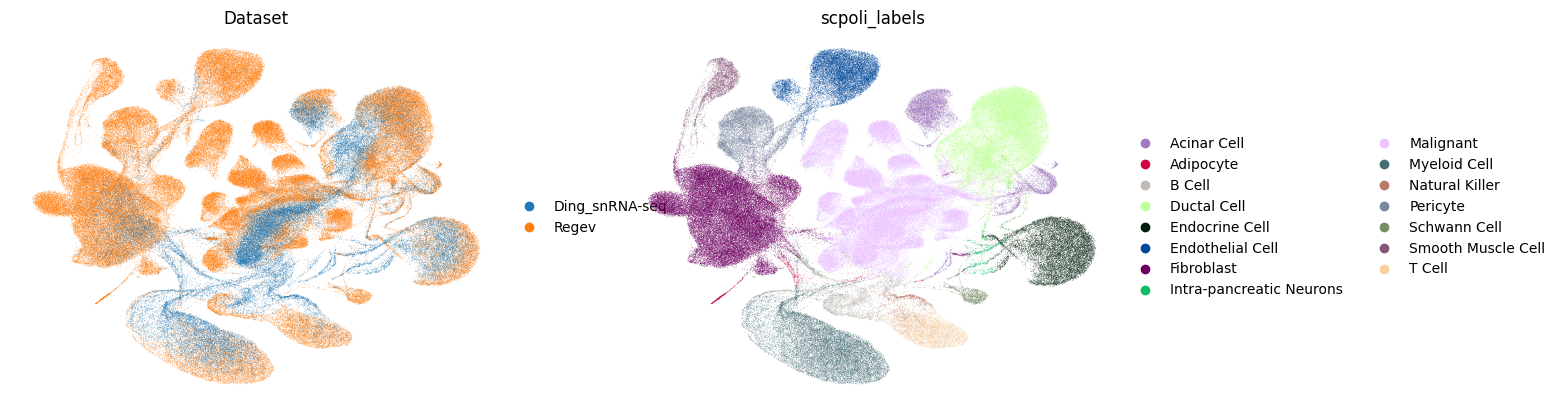

In [40]:
sc.pl.umap(adata_an_all, color=['Dataset', 'scpoli_labels'], frameon=False)

In [49]:
adata_an_all.obs['outlier'] = False
skip_list = ['Malignant', 'Ductal Cell', 'Acinar Cell']
for dataset in adata_an_all.obs['Dataset'].unique():
    for cell in adata_an_all.obs.loc[adata_an_all.obs['Dataset'] == dataset, 'scpoli_labels'].unique():
        if cell in skip_list:
            print(f'Skipping for {cell} in {dataset}')
            continue
        cell_mask = (adata_an_all.obs['Dataset'] == dataset) & (adata_an_all.obs['scpoli_labels'] == cell)
        total_outliers = pd.Series(False, index=adata_an_all.obs.index)
        outlier_total_counts = is_outlier(adata_an_all.obs.loc[cell_mask, 'log1p_total_counts'], 4)
        outlier_n_genes = is_outlier(adata_an_all.obs.loc[cell_mask, 'log1p_n_genes_by_counts'], 4)
        # outlier_mito = is_outlier(adata_an_all.obs.loc[cell_mask, 'pct_counts_mito'], 4)
        combined_outlier = outlier_total_counts | outlier_n_genes #| outlier_mito
        adata_an_all.obs.loc[cell_mask, 'outlier'] |= combined_outlier

Skipping for Ductal Cell in Regev
Skipping for Malignant in Regev
Skipping for Acinar Cell in Regev
Skipping for Malignant in Ding_snRNA-seq
Skipping for Ductal Cell in Ding_snRNA-seq
Skipping for Acinar Cell in Ding_snRNA-seq


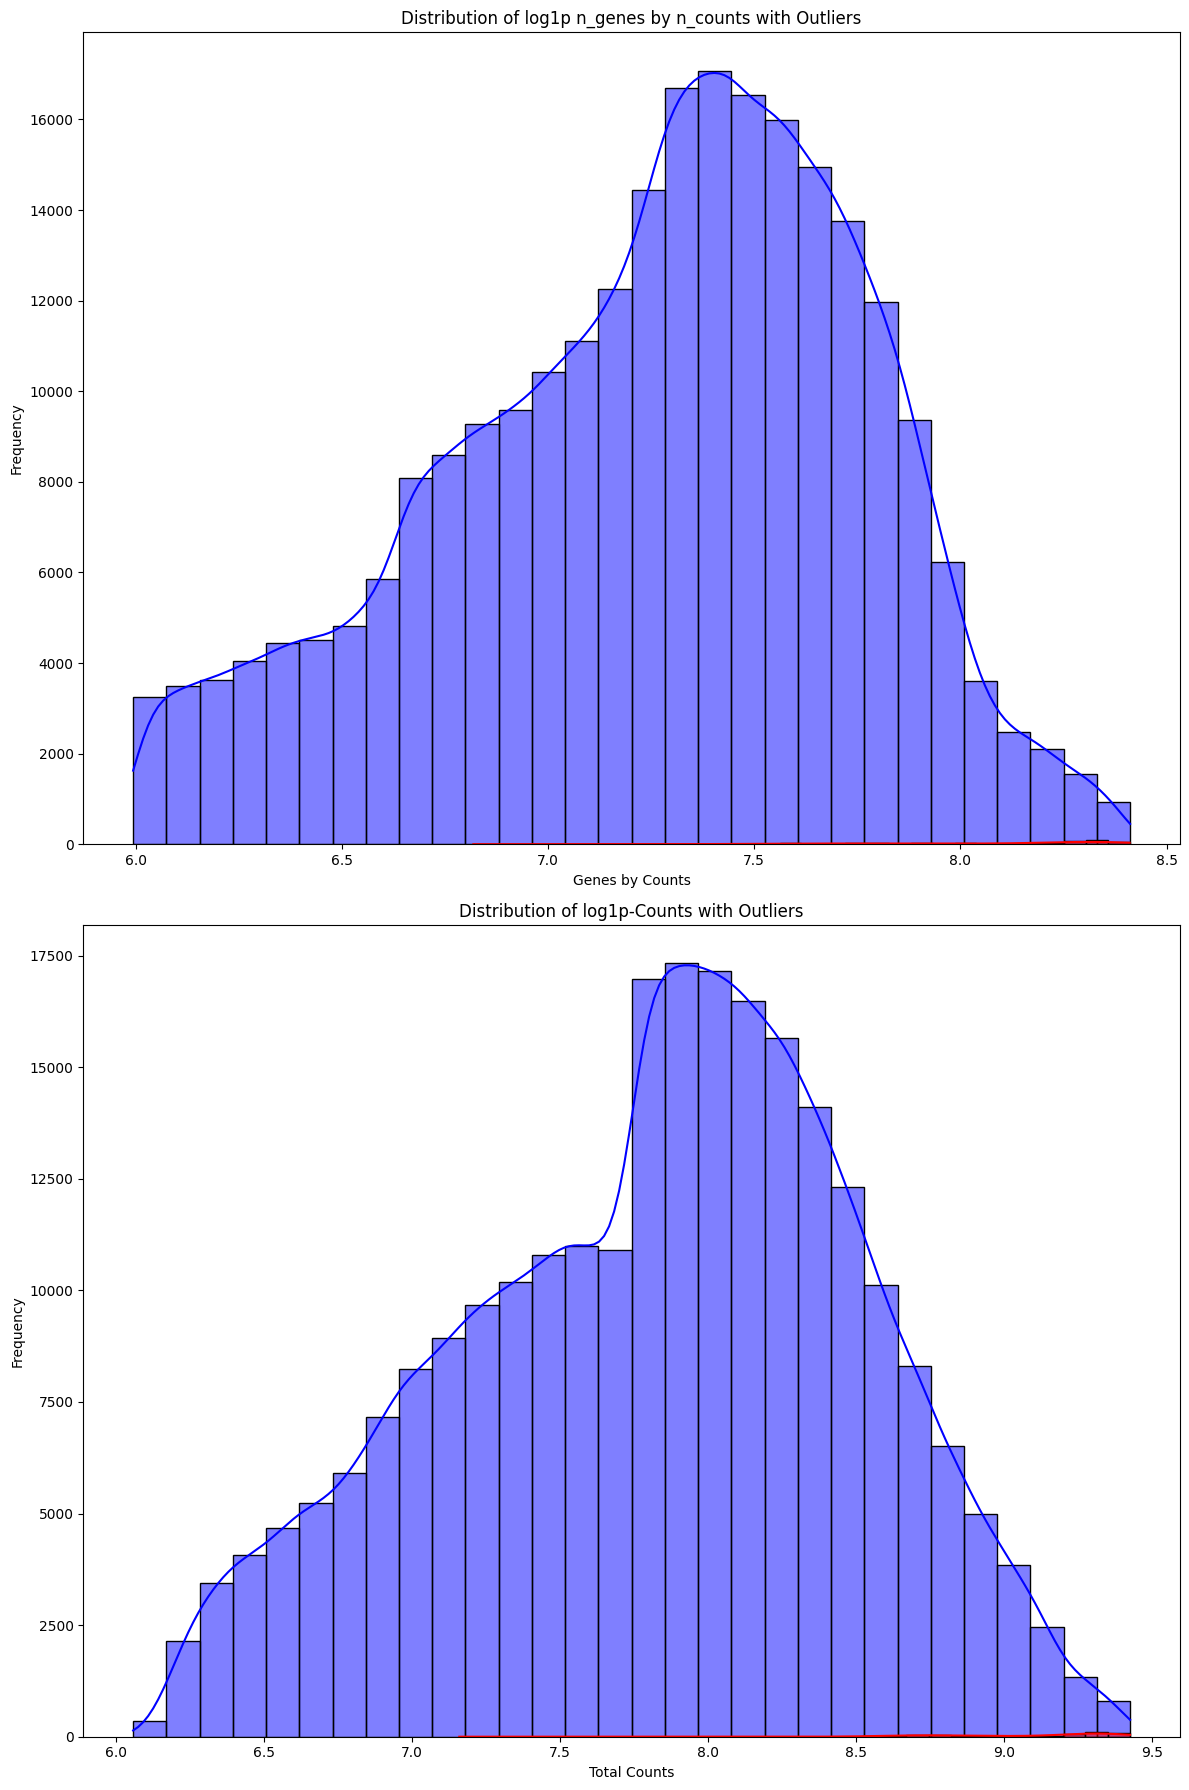

In [50]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(12, 18))
# plt.figure()
sns.histplot(adata_an_all.obs['log1p_n_genes_by_counts'], bins=30, kde=True, color="blue", label='Data', ax=ax1)
sns.histplot(adata_an_all.obs.loc[adata_an_all.obs['outlier'], 'log1p_n_genes_by_counts'], bins=30, kde=True, color="red", label='Outliers', ax=ax1)
ax1.set_xlabel('Genes by Counts')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of log1p n_genes by n_counts with Outliers')

sns.histplot(adata_an_all.obs['log1p_total_counts'], bins=30, kde=True, color="blue", label='Data', ax=ax2)
sns.histplot(adata_an_all.obs.loc[adata_an_all.obs['outlier'], 'log1p_total_counts'], bins=30, kde=True, color="red", label='Outliers', ax=ax2)
ax2.set_xlabel('Total Counts')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of log1p-Counts with Outliers')

plt.tight_layout()
plt.show()

In [51]:
size_filtered = adata_an_all[~adata_an_all.obs.outlier].obs.groupby('scpoli_labels').size()
size_unfiltered = adata_an_all.obs.groupby('scpoli_labels').size()
df = pd.DataFrame({
    'Unfiltered': size_unfiltered,
    'Filtered': size_filtered
})
df['Cells_Removed'] = df.Unfiltered - df.Filtered
df.loc["Total"] = df.sum()
df

,Unfiltered,Filtered,Cells_Removed
scpoli_labels,,,
Acinar Cell,11005,11005,0
Adipocyte,964,964,0
B Cell,4284,4226,58
Ductal Cell,34425,34425,0
Endocrine Cell,14210,14171,39
Endothelial Cell,16289,16277,12
Fibroblast,53305,53305,0
Intra-pancreatic Neurons,946,944,2
Malignant,70071,70071,0


In [52]:
size_filtered = adata_an_all[~adata_an_all.obs.outlier].obs.groupby('Dataset').size()
size_unfiltered = adata_an_all.obs.groupby('Dataset').size()
df = pd.DataFrame({
    'Unfiltered': size_unfiltered,
    'Filtered': size_filtered
})
df['Cells_Removed'] = df.Unfiltered - df.Filtered
df.loc["Total"] = df.sum()
df.sort_values(by='Cells_Removed', ascending=False)

,Unfiltered,Filtered,Cells_Removed
Dataset,,,
Total,251058,250600,458
Ding_snRNA-seq,59014,58650,364
Regev,192044,191950,94


In [53]:
adata_an_all.obs.groupby('outlier').size()

outlier
False    250600
True        458
dtype: int64

In [54]:
adata_an_all.obs.outlier = adata_an_all.obs.outlier.map({True: 1, False: 0})

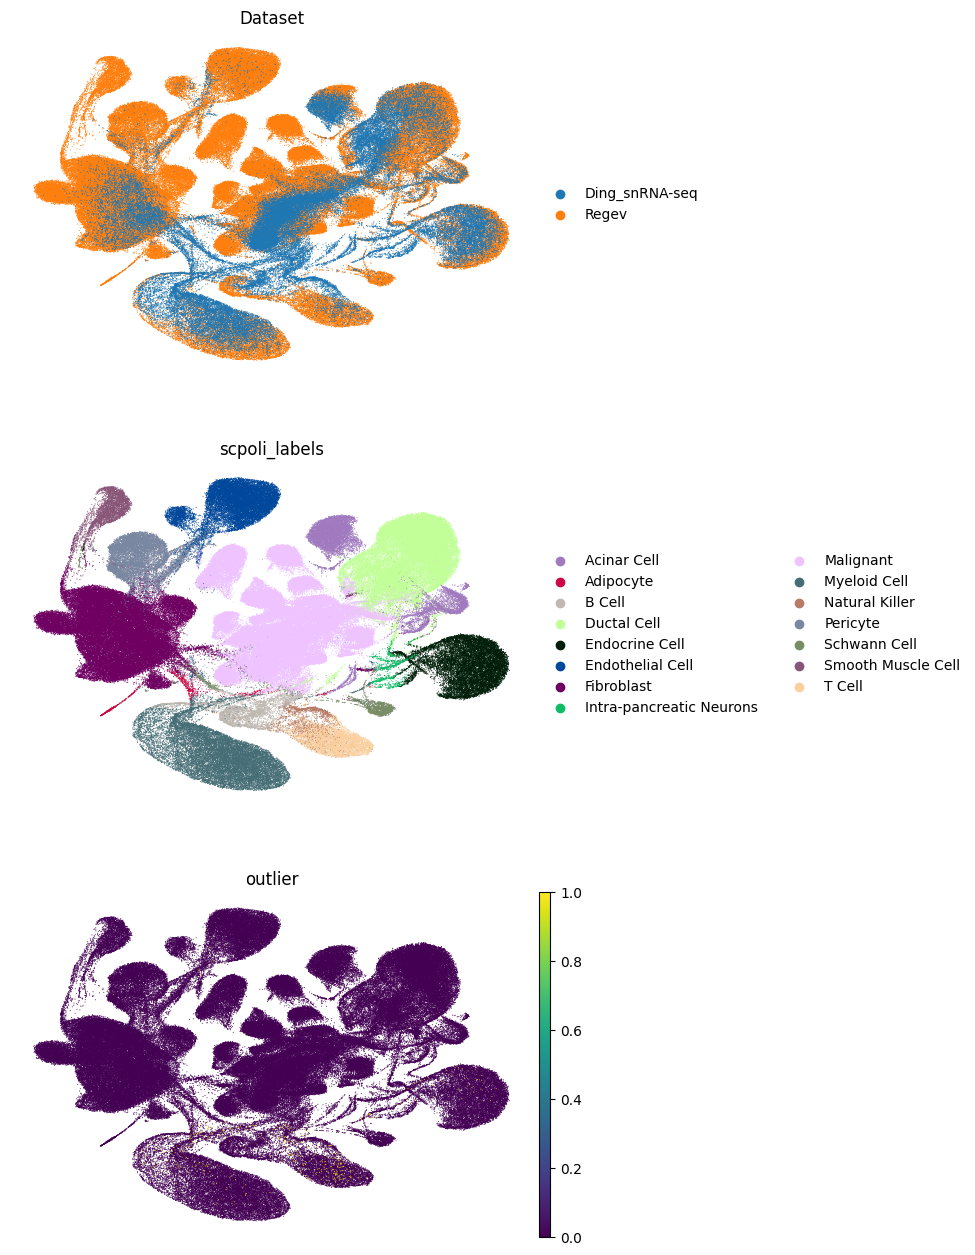

In [55]:
sc.pl.umap(adata_an_all, color=['Dataset', 'scpoli_labels', 'outlier'], frameon=False, ncols=1, size=2)

In [56]:
adata_an_all.write('../single_nuc_int/adata_nuc_int_outlier.h5ad')